In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew, boxcox
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
pd.options.mode.chained_assignment = None
import os

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [3]:
def scatter_plot(x, y):
    fig, ax = plt.subplots()
    ax.scatter(x = train_df[x], y = train_df[y])
    plt.ylabel(y, fontsize=13)
    plt.xlabel(x, fontsize=13)
    plt.show()

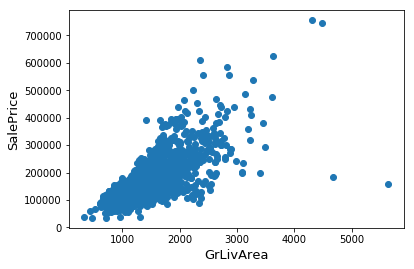

In [4]:
scatter_plot('GrLivArea', 'SalePrice')

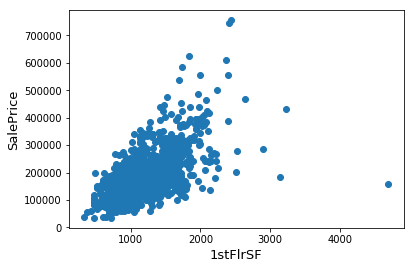

In [5]:
scatter_plot('1stFlrSF', 'SalePrice')

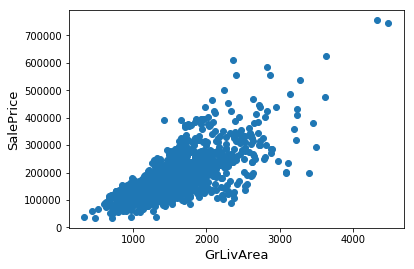

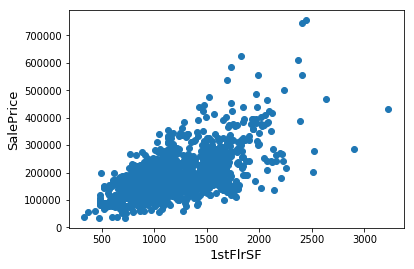

In [6]:
# Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
train_df = train_df.drop(train_df[(train_df['1stFlrSF']>4000) & (train_df['SalePrice']<200000)].index)

# Check the graphic again
scatter_plot('GrLivArea', 'SalePrice')
scatter_plot('1stFlrSF', 'SalePrice')

In [7]:
train_id_list = train_df['Id']
test_id_list = test_df['Id']
target = np.log(train_df['SalePrice'])

In [8]:
combined_df = pd.concat([train_df.drop(['SalePrice'], axis=1), test_df], sort=True)
print(combined_df.shape)

(2917, 80)


In [9]:
combined_df['MSSubClass'] = combined_df['MSSubClass'].apply(str)
combined_df['YrSold'] = combined_df['YrSold'].astype(str)
combined_df['MoSold'] = combined_df['MoSold'].astype(str)

In [10]:
print("Columns having null values {}".format(len(combined_df.columns[combined_df.isna().any()].tolist())))
row_count = combined_df.shape[0]
null_count_df = pd.DataFrame(combined_df.isnull().sum(), combined_df.columns, columns=['Nulls'])
null_count_df['Nulls'] = null_count_df['Nulls'].apply(lambda x: (x/row_count)*100)
null_count_df[null_count_df['Nulls'] > 10]

Columns having null values 34


,Nulls
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
MiscFeature,96.400411
PoolQC,99.691464


In [11]:
train_df['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

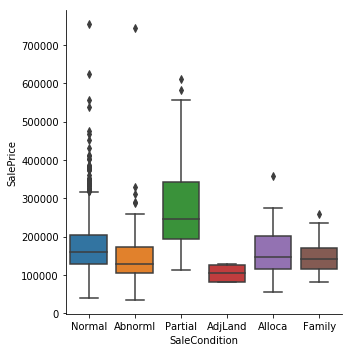

In [12]:
sns.catplot(x='SaleCondition', y='SalePrice', data=train_df, kind='box');

In [13]:
combined_df['HasAlley'] = combined_df['Alley'].apply(lambda x: 1 if x is not None else 0)
combined_df['HasFence'] = combined_df['Fence'].apply(lambda x: 1 if x is not None else 0)
combined_df['HasMisc'] = combined_df['MiscFeature'].apply(lambda x: 1 if x is not None else 0)
combined_df['Gar2Present'] = combined_df['MiscFeature'].apply(lambda x: 1 if x == 'Gar2' else 0)
combined_df['TencPresent'] = combined_df['MiscFeature'].apply(lambda x: 1 if x == 'Tenc' else 0)

In [14]:
combined_df = combined_df.drop(['Alley', 'Fence', 'MiscFeature', 'PoolQC'], axis=1)
print(combined_df.shape)

(2917, 81)


In [15]:
combined_df['FireplaceQu'] = combined_df['FireplaceQu'].fillna(combined_df['FireplaceQu'].mode())

In [16]:
num_cols = combined_df._get_numeric_data().columns
other_cols = list(set(combined_df.columns) - set(num_cols))

refined_df = combined_df
refined_df[other_cols] = refined_df[other_cols].fillna("NA")
for col in num_cols:
    refined_df[col] = refined_df[col].fillna(0)

In [17]:
print("Columns having null values {}".format(len(refined_df.columns[refined_df.isna().any()].tolist())))

Columns having null values 0


In [18]:
cat_cols_to_scale = ['ExterQual', 'ExterCond', 'GarageQual', 'GarageCond', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual']
# Scale above variables from 0 to 5
scale_dict = {'NA': 0, 'Po': 1, 'Fa': 4, 'TA': 9, 'Gd': 16, 'Ex': 25}

for col in cat_cols_to_scale:
    refined_df[col] = refined_df[col].map(scale_dict)

In [19]:
refined_df['TotalSF'] = refined_df['1stFlrSF'] + refined_df['2ndFlrSF'] + refined_df['BsmtUnfSF'] + refined_df['GrLivArea']
refined_df['TotalBaths'] = refined_df['BsmtFullBath'] + refined_df['BsmtHalfBath'] * 0.5 + \
refined_df['FullBath'] + 0.5 + refined_df['HalfBath']

In [20]:
# refined_df['HouseOldness'] = refined_df['YearBuilt'].apply(lambda x: 'Old' if x < 1953 else('Medium' if x < 2001 else 'New'))
refined_df['OverallQual'] = refined_df['OverallQual'] ** 2
refined_df['OverallCond'] = refined_df['OverallCond'] ** 2

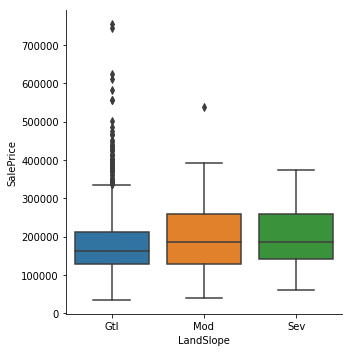

In [21]:
sns.catplot(x='LandSlope', y='SalePrice', data=train_df, kind='box');

In [22]:
refined_df['Utilities'] = refined_df['Utilities'].map({'AllPub': 16, 'NoSeWa': 1, 'NA': 0})
refined_df['HasPool'] = refined_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [23]:
refined_df['TotalBaths'].describe()

count    2917.000000
mean        2.906754
std         0.933513
min         1.500000
25%         2.500000
50%         2.500000
75%         3.500000
max         8.500000
Name: TotalBaths, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


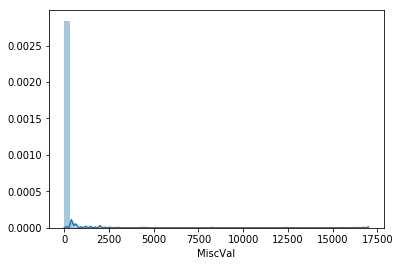

In [24]:
sns.distplot(refined_df['MiscVal']);

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


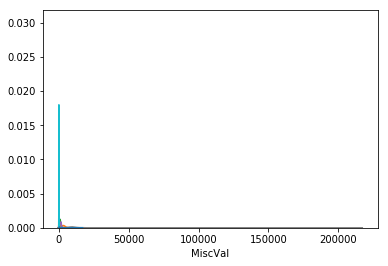

In [25]:
cols = ['1stFlrSF', 'TotalSF', 'TotalBsmtSF', 'BsmtUnfSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'MasVnrArea', 
        'LotFrontage', 'MiscVal']
for c  in cols:
    sns.distplot(refined_df[c]);
    refined_df[c] = refined_df[c].apply(lambda x: 1 if x == 0 else x)
    refined_df[c], l = boxcox(refined_df[c])

In [26]:
refined_df = pd.get_dummies(refined_df)
print(refined_df.shape)

(2917, 296)


In [27]:
train_data = refined_df[refined_df['Id'].isin(train_id_list)]
test_data = refined_df[refined_df['Id'].isin(test_id_list)]
train_data = train_data.drop(['Id'], axis=1)
test_data = test_data.drop(['Id'], axis=1)
print(train_data.shape)
print(test_data.shape)

(1458, 295)
(1459, 295)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.20, random_state=42)

In [29]:
def analyse_model(model):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("RMSE train data is %s" % math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("RMSE test data is %s" % math.sqrt(mean_squared_error(y_test, y_test_pred)))
    coeff_df = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])  
    print(coeff_df.describe())
    
    coeff_df = coeff_df.sort_values(by=['Coefficient'], ascending=False)
    return coeff_df

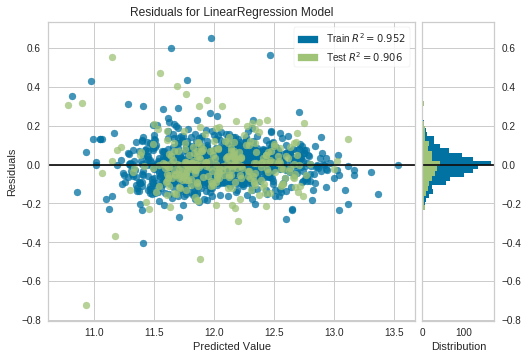

RMSE train data is 0.08671428844367998
RMSE test data is 0.12568384552896827
       Coefficient
count   295.000000
mean     -0.001495
std       0.089582
min      -0.907089
25%      -0.017145
50%       0.000170
75%       0.023426
max       0.468517


,Coefficient
SaleType_New,0.468517
HouseStyle_1.5Unf,0.197359
1stFlrSF,0.194960
Condition2_PosA,0.186638
SaleCondition_AdjLand,0.174972
Condition2_Feedr,0.174861
GrLivArea,0.148983
Exterior1st_Stone,0.143641
MSZoning_FV,0.140503
Neighborhood_StoneBr,0.126258


In [30]:
from yellowbrick.regressor import ResidualsPlot
linear_regr_model = LinearRegression()
analyse_model(linear_regr_model)

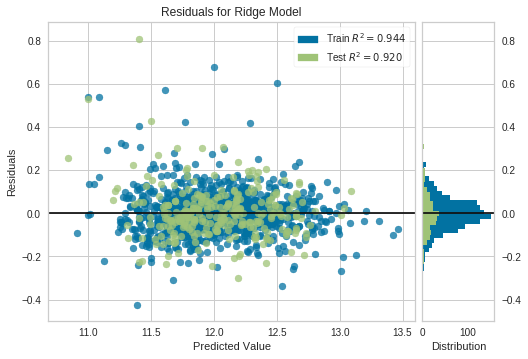

RMSE train data is 0.0935232178821803
RMSE test data is 0.11606356645166568
       Coefficient
count   295.000000
mean      0.000688
std       0.018767
min      -0.088579
25%      -0.008604
50%       0.000278
75%       0.009432
max       0.074893


,Coefficient
Neighborhood_StoneBr,0.074893
Neighborhood_Crawfor,0.071354
Functional_Typ,0.063112
Exterior1st_BrkFace,0.057915
1stFlrSF,0.057040
MSZoning_FV,0.049147
Neighborhood_BrkSide,0.048828
TotalSF,0.048340
SaleType_New,0.045936
Street_Pave,0.039674


In [31]:
ridge_model = Ridge(alpha=10)
analyse_model(ridge_model)

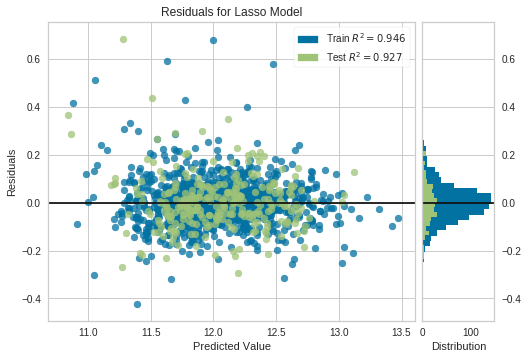

RMSE train data is 0.09207630375037745
RMSE test data is 0.11075060741293768
       Coefficient
count   295.000000
mean     -0.001088
std       0.029246
min      -0.284242
25%      -0.000000
50%       0.000000
75%       0.000749
max       0.156117


,Coefficient
1stFlrSF,0.156117
Neighborhood_StoneBr,0.117991
Neighborhood_Crawfor,0.103321
Exterior1st_BrkFace,0.077489
Neighborhood_BrkSide,0.065930
Functional_Typ,0.065673
SaleType_New,0.055898
Neighborhood_NridgHt,0.053187
MSZoning_FV,0.052946
BsmtExposure_Gd,0.047366


In [32]:
lasso_model = Lasso(alpha=0.0002)
analyse_model(lasso_model)

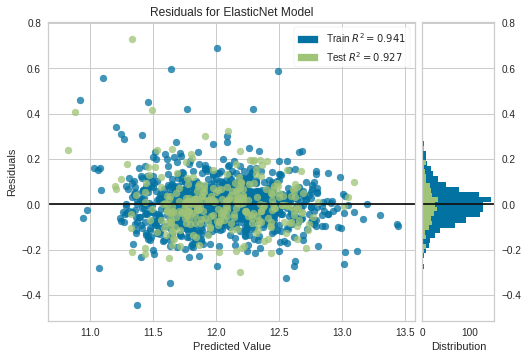

RMSE train data is 0.0961287250080443
RMSE test data is 0.11092242276689668
       Coefficient
count   295.000000
mean      0.001129
std       0.021586
min      -0.229534
25%       0.000000
50%       0.000000
75%       0.000000
max       0.116178


,Coefficient
1stFlrSF,0.116178
Neighborhood_StoneBr,0.094118
Neighborhood_Crawfor,0.093513
Exterior1st_BrkFace,0.078458
SaleType_New,0.073407
Functional_Typ,0.068390
Neighborhood_BrkSide,0.057326
TotalSF,0.051937
MSZoning_FV,0.042389
BsmtExposure_Gd,0.042041


In [33]:
elastic_net_model = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
analyse_model(elastic_net_model)

In [34]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data.values)
    rmse= np.sqrt(-cross_val_score(model, train_data.values, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [35]:
score = rmsle_cv(ridge_model)
print("Ridge Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge Model score: 0.1093 (0.0147)



In [36]:
score = rmsle_cv(lasso_model)
print("Lasso Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Lasso Model score: 0.1081 (0.0155)



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [37]:
score = rmsle_cv(elastic_net_model)
print("ElasticNet Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet Model score: 0.1072 (0.0147)



In [38]:
# alphas = [5.0, 8.0, 10.0, 12.0, 15.0, 17.0, 20.0]
# for alpha in alphas:
#     ridge_model = Ridge(alpha=alpha)
#     score = rmsle_cv(ridge_model)
#     print("Ridge Model score with alpha as: {} {:.4f} ({:.4f})\n".format(alpha, score.mean(), score.std()))

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [40]:
averaged_models = AveragingModels(models = (elastic_net_model, ridge_model, lasso_model))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

 Averaged base models score: 0.1075 (0.0149)



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [41]:
# # ridge_model = Ridge(10)
# # print(ridge_model)
# # analyse_model(ridge_model)
# elastic_net_model = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
# analyse_model(elastic_net_model)

In [42]:
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
test_set = test_data

averaged_models = AveragingModels(models = (elastic_net_model, ridge_model, lasso_model))
averaged_models.fit(X_train, y_train)
predictions = averaged_models.predict(test_set)
submission['SalePrice'] = np.exp(predictions)
submission.to_csv('submission.csv', index=False)